<a href="https://colab.research.google.com/github/romanzelararg/GRUPO-11---Proyecto-Final-Cohorte-2022-/blob/main/Copia_de_ISPC_Piletas_Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detección de piletas utilizando imágenes satelitales y deep learning.

El procesamiento de imágenes, combinado con la el machine learning, ofrece un gran potencial para la ciencia de datos. Un ejemplo de aplicación y uso para la Gestion Urbana es la detección de piletas.

Mediante el framework Raster Vision se propone realizar el procedimiento completo de aprendizaje profundo geoespacial: leer datos georreferenciados, entrenar modelos, realizar predicciones y escribir predicciones en formatos georreferenciados.

Dataset de imágenes satelitales obtenido de la página web del gobierno de la Ciudad de Buenos Aires (https://buenosaires.gob.ar/).


#### Se propone desarrollar un sistema automatizado que use:
- Imágenes satelitales de alta resolución para identificar posibles piletas.
- Algoritmos de aprendizaje profundo, entrenados para reconocer formas y reflejos de agua en las imágenes.

#### Este sistema podría implementarse por entidades recaudadoras para:
- Reducir la evasión fiscal
- Aumentar la equidad tributaria
- Optimizar recursos en la fiscalización


##### Integrantes
- Romina Yael Hanun
- Federico Juchniewicz
- Samuel Kanneman
- Carla Lucero
- Leonardo Matías Mansilla
- Román Zelarayán






In [ ]:
%%sh
rm -rf raster-vision/
git clone https://github.com/azavea/raster-vision.git
# Clona el repositorio 'raster-vision' de GitHub en el directorio actual.

Cloning into 'raster-vision'...


In [ ]:
!pip install raster-vision/rastervision_pipeline/
!pip install raster-vision/rastervision_core/
!pip install raster-vision/rastervision_pytorch_learner/
!pip install raster-vision/rastervision_aws_s3/
!pip install raster-vision/rastervision_pytorch_backend/

!pip install gdown

Processing ./raster-vision/rastervision_pipeline
  Preparing metadata (setup.py) ... done
  Created wheel for rastervision-pipeline: filename=rastervision_pipeline-0.30.2.dev0-py3-none-any.whl size=37074 sha256=d5eabcabc3d2b907d933181986c3f1f64c03252b92cc071a848f5c5f330867a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0vfz_49/wheels/a2/b0/40/6e81e96fd508b92025df1bc01df0429c6c12379fa7c7c3306e
Successfully built rastervision-pipeline
  Attempting uninstall: rastervision-pipeline
    Found existing installation: rastervision-pipeline 0.30.2.dev0
    Uninstalling rastervision-pipeline-0.30.2.dev0:
      Successfully uninstalled rastervision-pipeline-0.30.2.dev0


Processing ./raster-vision/rastervision_core
  Preparing metadata (setup.py) ... done
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 443, in resolve
    n

In [ ]:
!sudo apt-get install gdal-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from subprocess import check_output

# Establece la variable de entorno 'GDAL_DATA' para especificar la ubicación de los datos de GDAL.
# GDAL es una biblioteca para leer y escribir formatos de datos geoespaciales.
# 'check_output' ejecuta un comando en la shell y devuelve su salida.
os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()

# Establece la variable de entorno 'AWS_NO_SIGN_REQUEST' para permitir el acceso no autenticado a los datos de AWS S3.
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

import glob

# Importa clases de Raster Vision para trabajar con fuentes de datos ráster y transformadores.
from rastervision.core.data import RasterioSource, MinMaxTransformer

# Importa varias clases de Raster Vision para trabajar con datos vectoriales, transformadores y configuraciones de clases.
from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

# Importa la clase para fuentes de etiquetas de segmentación semántica.
from rastervision.core.data import SemanticSegmentationLabelSource

# Utilidades para trabajar con datos GeoJSON y geometrías.
from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

# Importa clases de Raster Vision para conjuntos de datos, visualización y aprendizaje profundo con PyTorch.
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

# Importa configuraciones y clases de aprendizaje para segmentación semántica con PyTorch.
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner

"""
En resumen, este código configura el entorno para trabajar con datos geoespaciales, define las transformaciones necesarias para los datos ráster y vectoriales,
y prepara el entrenamiento de un modelo de segmentación semántica utilizando PyTorch a través de Raster Vision.
Además, se asegura de que los datos necesarios de GDAL estén disponibles y permite el acceso a los datos almacenados en AWS S3 sin necesidad de autenticación.
"""


In [ ]:
#image_url = "https://drive.google.com/file/d/1KsNHdTzS1pCNqBxdgj8l8-3C2FqZUX-E/view?usp=drive_link"
image_file_dest = "/content/drive/MyDrive/Deteccion/anotaciones/img_SAS_wgs_r.tif"

In [ ]:
#!wget $image_url -O $image_file_dest

In [ ]:
import gdown

!mkdir -p /content/drive/MyDrive/Deteccion/anotaciones/

annotations_url = "https://drive.google.com/file/d/1V9N0xDJKApR_p3PlFZ-9xSvMWWh1Xv3o/view?usp=drive_link"
annotations_file_dest = "/content/drive/MyDrive/Deteccion/anotaciones/anotaciones_wgs_geoj_r2.geojson"

gdown.download(annotations_url, annotations_file_dest, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1V9N0xDJKApR_p3PlFZ-9xSvMWWh1Xv3o
To: /content/drive/MyDrive/Deteccion/anotaciones/anotaciones_wgs_geoj_r2.geojson
100%|██████████| 75.6k/75.6k [00:00<00:00, 13.2MB/s]


'/content/drive/MyDrive/Deteccion/anotaciones/anotaciones_wgs_geoj_r2.geojson'

In [ ]:
#AoI_url = "https://drive.google.com/file/d/1zwMNe7AydcPF00cWOuxLY_rB1oB1jmDz/view?usp=drive_link"
AoI_file_dest = "/content/drive/MyDrive/Deteccion/anotaciones/sector_geoj_wgs84_r2.geojson"

#gdown.download(AoI_url, AoI_file_dest, fuzzy=True)

"""
área de interés, almacenado en Google Drive.
El archivo en cuestión es un archivo .geojson, que es un formato de archivo abierto para representar datos geoespaciales simples.
Los archivos GeoJSON contienen información geográfica, como puntos, líneas y polígonos, junto con otros datos en formato JSON.
"""


In [ ]:
# clases - Piletas y background
# Esta sección define las clases que el modelo intentará identificar en las imágenes.
# 'background' y 'pileta' son las dos clases definidas.
# 'background' se refiere a todo lo que no es una pileta, y 'pileta' se refiere a las piscinas.

class_config = ClassConfig(
    names=['background', 'pileta'],
    # Nombres de las clases.
    colors=['lightgray', 'darkred'],
    # Colores para visualizar las clases.
    null_class='background')
 # La clase 'background' se utiliza para áreas no etiquetadas.


# tamaño en píxeles de los recortes cuadrados
# 'window_size' define el tamaño de los recortes (ventanas) que se extraerán de las imágenes para entrenar el modelo.
# En este caso, cada recorte será un cuadrado de 250x250 píxeles.
window_size = 250

# transformaciones a realizar a los recorte del dataset
# 'data_augmentation_transform' define una serie de transformaciones para aumentar la cantidad de datos de entrenamiento.
# Estas transformaciones alteran las imágenes de maneras que pueden ocurrir naturalmente, ayudando al modelo a generalizar mejor.

data_augmentation_transform = A.Compose([
    A.Flip(),
    # Voltea las imágenes horizontal o verticalmente.
    A.ShiftScaleRotate(),
    # Aplica pequeños desplazamientos, escalados y rotaciones a las imágenes.
    A.OneOf([
        # Aplica una de las siguientes transformaciones:
        A.HueSaturationValue(hue_shift_limit=10),
        # Cambia el tono y la saturación.
        A.RandomBrightness(),
        # Ajusta el brillo de manera aleatoria.
        A.RandomGamma(),
         # Ajusta la gamma de manera aleatoria.
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
    # Crea 'agujeros' en la imagen.
])

"""
En resumen, este código configura las clases para la segmentación, define el tamaño de las ventanas de entrenamiento
y establece una serie de transformaciones de aumento de datos para mejorar la robustez del modelo de aprendizaje automático.
Las transformaciones de aumento de datos son técnicas comunes para aumentar artificialmente la diversidad de los datos de entrenamiento sin recopilar nuevos datos,
lo que puede mejorar la capacidad del modelo para generalizar a nuevas imágenes.
"""


In [ ]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    # Configuración de las clases definidas anteriormente (background y pileta).
    aoi_uri=AoI_file_dest,
    # Ruta al archivo GeoJSON que define el Área de Interés (AoI).
    image_uri=image_file_dest,
    # Ruta al archivo de imagen ráster que se utilizará para la validación.

    label_vector_uri=annotations_file_dest,
    # Ruta al archivo de anotaciones vectoriales para las etiquetas.

    label_vector_default_class_id=class_config.get_class_id('pileta'),
     # ID de la clase por defecto para las etiquetas vectoriales.

    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    # Palabras clave para la fuente de imagen ráster, permitiendo streaming y aplicando transformaciones.
    size=window_size,
    # Tamaño de las ventanas de imagen que se extraerán para la validación.
    stride=window_size,
    # Distancia entre las ventanas consecutivas (en este caso, no hay superposición).
    transform=A.Resize(window_size, window_size)
    # Transformación para redimensionar las ventanas al tamaño especificado.
    )

"""
En resumen, este código prepara un conjunto de datos de validación que se utilizará para evaluar la precisión de un modelo de segmentación semántica,
asegurándose de que las imágenes de entrada y las etiquetas estén correctamente alineadas y transformadas para el proceso de validación.
"""


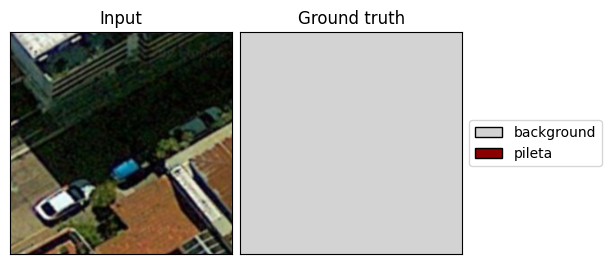

In [ ]:
import random

# Esta función genera un número entero aleatorio entre 1 y 200.
def generar_numero_aleatorio():
    return random.randint(1, 200)

# Aquí se llama a la función para obtener un número aleatorio y se almacena en la variable 'numero_aleatorio'.
numero_aleatorio = generar_numero_aleatorio()

# Se crea una instancia de 'SemanticSegmentationVisualizer' con los nombres y colores de las clases definidos anteriormente.
# SemanticSegmentationVisualizer es una clase de Raster Vision que se utiliza para visualizar los resultados de la segmentación semántica.
#Se inicializa con los nombres y colores de las clases para que pueda mostrar correctamente las predicciones de segmentación.
vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

# Se obtiene un par de datos (imagen y etiqueta) del conjunto de datos de validación usando el índice aleatorio.
x, y = val_ds[numero_aleatorio]

# Finalmente, se visualiza el par de datos. 'unsqueeze(0)' agrega una dimensión extra al tensor para simular un lote de tamaño 1.
vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

"""
En resumen, este código selecciona aleatoriamente un ejemplo del conjunto de datos de validación y utiliza SemanticSegmentationVisualizer
para visualizar la imagen junto con su etiqueta de segmentación semántica.
Esto es útil para verificar la calidad de las etiquetas o para inspeccionar los resultados de las predicciones del modelo.
"""


In [ ]:
# Se obtiene el tamaño del conjunto de datos de validación para usarlo como referencia.
sample_size = len(val_ds)

# Se crea un conjunto de datos de entrenamiento utilizando la clase 'SemanticSegmentationRandomWindowGeoDataset'.
train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    # Configuración de las clases (background y pileta).
    aoi_uri=AoI_file_dest,
    # Ruta al archivo GeoJSON que define el Área de Interés (AoI).
    image_uri=image_file_dest,
    # Ruta al archivo de imagen ráster que se utilizará para el entrenamiento.

    label_vector_uri=annotations_file_dest,
    # Ruta al archivo de anotaciones vectoriales para las etiquetas.

    label_vector_default_class_id=class_config.get_class_id('pileta'),
    # ID de la clase por defecto para las etiquetas vectoriales.

    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    # Palabras clave para la fuente de imagen ráster, permitiendo streaming y aplicando transformaciones.
    # Las dimensiones de las ventanas se fijan a un tamaño específico.

    # window sizes will randomly vary from 100x100 to 300x300
    #size_lims=(100, 300),
    # fixed window size
    size_lims=(window_size, window_size+1),
     # Se redimensionan los recortes antes de devolverlos.
    # resize chips before returning
    out_size=window_size,
    # Se permite que las ventanas se desborden del área de interés por 100 píxeles.
    # allow windows to overflow the extent by 100 pixels
    padding=100,
    # Se limita el número máximo de ventanas a la longitud del conjunto de datos de validación.
    max_windows=sample_size, # pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
     # Se aplican transformaciones de aumento de datos definidas anteriormente.
    transform=data_augmentation_transform
)

"""
En resumen, este código prepara un conjunto de datos de entrenamiento con ventanas de imágenes y etiquetas correspondientes,
listo para ser utilizado en el entrenamiento de un modelo de segmentación semántica.
Las ventanas se generan de manera aleatoria y se aplican transformaciones para aumentar la diversidad de los datos.
"""


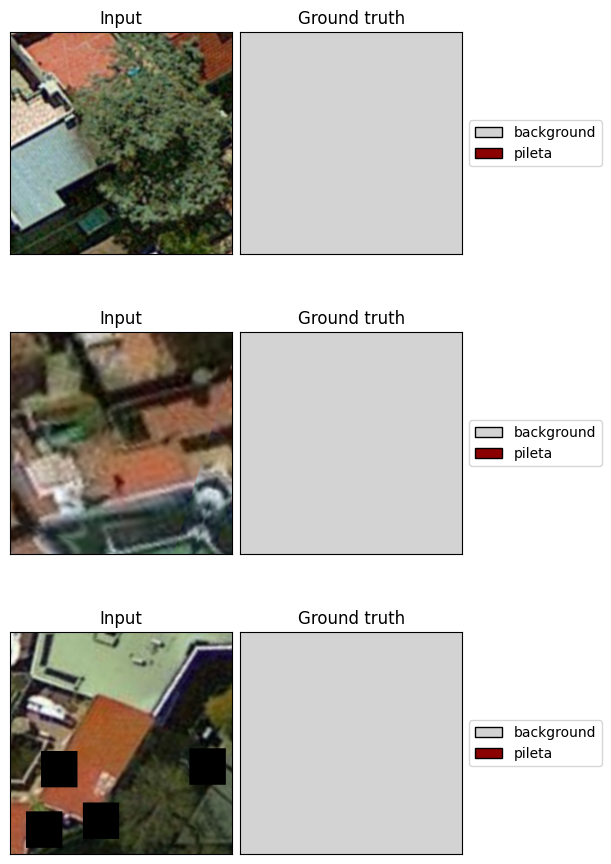

In [ ]:
# Esta línea obtiene un lote de tres ejemplos (imágenes y etiquetas) del conjunto de datos de entrenamiento.
x, y = vis.get_batch(train_ds, 3)

# Esta línea utiliza el visualizador 'vis' para mostrar el lote de datos.
# 'plot_batch' toma los tensores de imágenes y etiquetas y los visualiza.
# 'show=True' indica que las imágenes deben mostrarse inmediatamente.
vis.plot_batch(x, y, show=True)

"""
En resumen, este código está seleccionando un pequeño lote de ejemplos del conjunto de datos de entrenamiento y los está visualizando
para inspeccionar la calidad de las imágenes y las etiquetas o para verificar los resultados de las predicciones del modelo.
Esto es útil para entender cómo el modelo está interpretando los datos y para asegurarse de que el proceso de entrenamiento está funcionando como se espera.
"""


In [ ]:
"""
Este fragmento de código en Python está utilizando la biblioteca torch.hub para cargar un modelo preentrenado de red neuronal.
"""

import torch
# Carga un modelo preentrenado desde un repositorio de GitHub utilizando torch.hub.

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    # Especifica el repositorio y la versión del modelo.
    'make_fpn_resnet',
    # Nombre de la función para crear el modelo Feature Pyramid Network (FPN) basado en ResNet.
    name='resnet18',
    # Especifica que se utilizará la arquitectura ResNet-18.
    fpn_type='panoptic',
    # Tipo de FPN, en este caso 'panoptic' para segmentación panóptica.
    num_classes=len(class_config),
    # Número de clases para la clasificación, basado en la configuración de clases.
    fpn_channels=128,
    # Número de canales en las capas de la FPN.
    in_channels=3,
    # Número de canales de entrada, típicamente 3 para imágenes RGB.
    out_size=(window_size, window_size),
    # Tamaño de salida de las predicciones del modelo.
    pretrained=True)
    # Indica que se cargará un modelo preentrenado.

"""
En resumen, este código está preparando un modelo de segmentación panóptica basado en ResNet-18 y FPN para ser utilizado en tareas de visión por computadora,
particularmente para la segmentación semántica de imágenes geoespaciales.
El modelo está preentrenado, lo que significa que ya ha aprendido características útiles de un conjunto de datos grande y solo necesita ser afinado para la tarea específica.
"""


Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_0.3


In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner

In [ ]:
# Donde vamos a guardar el modelo entrenado
model_folder =  "/content/drive/MyDrive/Deteccion/"
# cantidad de iteraciones
n_epochs = 2

# cantidad de imagenes a cargar por iteración
# (limitada por la cantidad de memoria GPU y de memoria RAM)
# en los 15Gb RAM de la GPU de Google Colab entran tandas
# de hasta 60 imagenes de 480x480px

batch_images = 60
# Cuál es la configuración de clases a identidicar
data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0, # increase to use multi-processing
)

In [ ]:
# Cuántas imágenes a cargar en memoria a la vez
solver_cfg = SolverConfig(
    batch_sz=batch_images,
    lr=0.01
)


In [ ]:
# combinamos todas las opciones en un objeto "learner",
# que es el que realizará el entrenamiento


from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [ ]:
"""
Este fragmento de código está utilizando la biblioteca Raster Vision para configurar un aprendiz (learner) para la tarea de segmentación semántica,
que es un tipo de modelo de aprendizaje profundo utilizado para clasificar cada píxel de una imagen en una categoría.
"""

from rastervision.pytorch_learner import SemanticSegmentationLearner

# Se crea una instancia de SemanticSegmentationLearner, que es una clase de Raster Vision
# diseñada para facilitar el entrenamiento de modelos de segmentación semántica.
learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    # Configuración del aprendiz, que incluye hiperparámetros y configuraciones del modelo.
    output_dir=model_folder,
    # Directorio donde se guardarán los resultados del entrenamiento, como los pesos del modelo.
    model=model,
    # El modelo de red neuronal que se va a entrenar, previamente cargado.
    train_ds=train_ds,
    # Conjunto de datos de entrenamiento, que contiene las imágenes y las etiquetas correspondientes.
    valid_ds=val_ds,
    # Conjunto de datos de validación, utilizado para evaluar el rendimiento del modelo.
)

"""
En resumen, este código está preparando un “learner” para entrenar un modelo de segmentación semántica, especificando la configuración,
el modelo y los conjuntos de datos necesarios para el proceso de entrenamiento.
Una vez configurado, el “learner” puede ser utilizado para iniciar el entrenamiento y desarrollar un modelo que pueda clasificar píxeles en imágenes geoespaciales.
"""


2024-05-17 00:22:44:rastervision.pytorch_learner.learner: INFO - Building dataloaders
INFO:rastervision.pytorch_learner.learner:Building dataloaders


In [ ]:
# Llama al método log_data_stats() del objeto learner.
learner.log_data_stats()

"""
En resumen, learner.log_data_stats() es una herramienta de diagnóstico que proporciona una visión general de los datos con los que se está trabajando,
asegurando que el proceso de entrenamiento se base en un fundamento sólido y bien informado.
"""


2024-05-17 00:22:49:rastervision.pytorch_learner.learner: INFO - train_ds: 241 items
INFO:rastervision.pytorch_learner.learner:train_ds: 241 items
2024-05-17 00:22:49:rastervision.pytorch_learner.learner: INFO - valid_ds: 241 items
INFO:rastervision.pytorch_learner.learner:valid_ds: 241 items


In [ ]:
# Inicia el proceso de entrenamiento del modelo con un número específico de épocas.
learner.train(epochs=2)

"""
En resumen, learner.train(epochs=2) pone en marcha el entrenamiento del modelo durante dos épocas completas,
permitiendo que el modelo aprenda de los datos y mejore su capacidad de hacer predicciones precisas sobre nuevas imágenes.
"""


2024-05-17 00:22:52:rastervision.pytorch_learner.learner: INFO - train_ds: 241 items
INFO:rastervision.pytorch_learner.learner:train_ds: 241 items
2024-05-17 00:22:52:rastervision.pytorch_learner.learner: INFO - valid_ds: 241 items
INFO:rastervision.pytorch_learner.learner:valid_ds: 241 items
2024-05-17 00:22:52:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
INFO:rastervision.pytorch_learner.learner:Plotting sample training batch.
2024-05-17 00:23:12:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
INFO:rastervision.pytorch_learner.learner:Plotting sample validation batch.
2024-05-17 00:23:29:rastervision.pytorch_learner.learner: INFO - epoch: 0
INFO:rastervision.pytorch_learner.learner:epoch: 0


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

2024-05-17 00:27:48:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.03138914704322815,
 'train_time': '0:03:08.118398',
 'val_loss': 0.027559751644730568,
 'avg_precision': 0.9937865734100342,
 'avg_recall': 0.9937474727630615,
 'avg_f1': 0.9937670230865479,
 'background_precision': 0.9937474131584167,
 'background_recall': 1.0,
 'background_f1': 0.9968639016151428,
 'pileta_precision': 1.0,
 'pileta_recall': 0.0017489189049229026,
 'pileta_f1': 0.0034917311277240515,
 'valid_time': '0:01:11.333488'}
INFO:rastervision.pytorch_learner.learner:metrics:
{'epoch': 0,
 'train_loss': 0.03138914704322815,
 'train_time': '0:03:08.118398',
 'val_loss': 0.027559751644730568,
 'avg_precision': 0.9937865734100342,
 'avg_recall': 0.9937474727630615,
 'avg_f1': 0.9937670230865479,
 'background_precision': 0.9937474131584167,
 'background_recall': 1.0,
 'background_f1': 0.9968639016151428,
 'pileta_precision': 1.0,
 'pileta_recall': 0.0017489189049229026,
 'pileta_

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validating:   0%|          | 0/5 [00:00<?, ?it/s]

2024-05-17 00:32:12:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 1,
 'train_loss': 0.028610169887542725,
 'train_time': '0:03:06.949056',
 'val_loss': 0.024875828996300697,
 'avg_precision': 0.9875122308731079,
 'avg_recall': 0.9937365055084229,
 'avg_f1': 0.9906145930290222,
 'background_precision': 0.9937365055084229,
 'background_recall': 1.0,
 'background_f1': 0.9968584179878235,
 'pileta_precision': 0.0,
 'pileta_recall': 0.0,
 'pileta_f1': 0.0,
 'valid_time': '0:01:17.136415'}
INFO:rastervision.pytorch_learner.learner:metrics:
{'epoch': 1,
 'train_loss': 0.028610169887542725,
 'train_time': '0:03:06.949056',
 'val_loss': 0.024875828996300697,
 'avg_precision': 0.9875122308731079,
 'avg_recall': 0.9937365055084229,
 'avg_f1': 0.9906145930290222,
 'background_precision': 0.9937365055084229,
 'background_recall': 1.0,
 'background_f1': 0.9968584179878235,
 'pileta_precision': 0.0,
 'pileta_recall': 0.0,
 'pileta_f1': 0.0,
 'valid_time': '0:01:17.136415'}


In [ ]:
# Guarda el modelo entrenado y la configuración asociada en un archivo.
learner.save_model_bundle()

"""
Este “paquete de modelo” es útil porque contiene todo lo necesario para cargar el modelo
y utilizarlo para hacer predicciones en otro momento o en otro lugar sin tener que reconfigurar o reentrenar el modelo desde cero.
"""


2024-05-17 00:40:00:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-05-17 00:40:00:rastervision.pytorch_learner.learner: INFO - Creating bundle.
INFO:rastervision.pytorch_learner.learner:Creating bundle.
2024-05-17 00:40:04:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
INFO:rastervision.pytorch_learner.learner:Exporting to model to ONNX.
2024-05-17 00:40:21:rastervision.pytorch_learner.learner: INFO - Saving bundle to /content/drive/MyDrive/Deteccion/model-bundle.zip.
INFO:rastervision.pytorch_learner.learner:Saving bundle to /content/drive/MyDrive/Deteccion/model-bundle.zip.


Zipping: 0it [00:00, ?it/s, learner-config.json]